In [ ]:
%pip install lightgbm

In [1]:
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
import pickle
import shap
import lime.lime_tabular
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import warnings
warnings.filterwarnings("ignore")

# Load your data (assuming output.csv is your dataset)
data = pd.read_csv("output.csv")
data = data.drop_duplicates()

# Prepare your features and target (adjust columns as needed)
X = data.drop(columns=['gravity', 'AccID', 'vehicleID', 'num_veh'], errors='ignore')
y = data['gravity']

# Split data (this is optional if you only need the final model)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train your model
model = LGBMClassifier(n_estimators=200, learning_rate=0.05, boosting_type='gbdt', random_state=42)
model.fit(X_train, y_train)

# Save the trained model
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

# Optionally, save your test data if you want to use it in Streamlit later
X_test.to_csv("X_test.csv", index=False)


  File "C:\Users\sd10725\AppData\Roaming\Python\Python311\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1953
[LightGBM] [Info] Number of data points in the train set: 358082, number of used features: 37
[LightGBM] [Info] Start training from score -0.867617
[LightGBM] [Info] Start training from score -3.690003
[LightGBM] [Info] Start training from score -1.887602
[LightGBM] [Info] Start training from score -0.907226


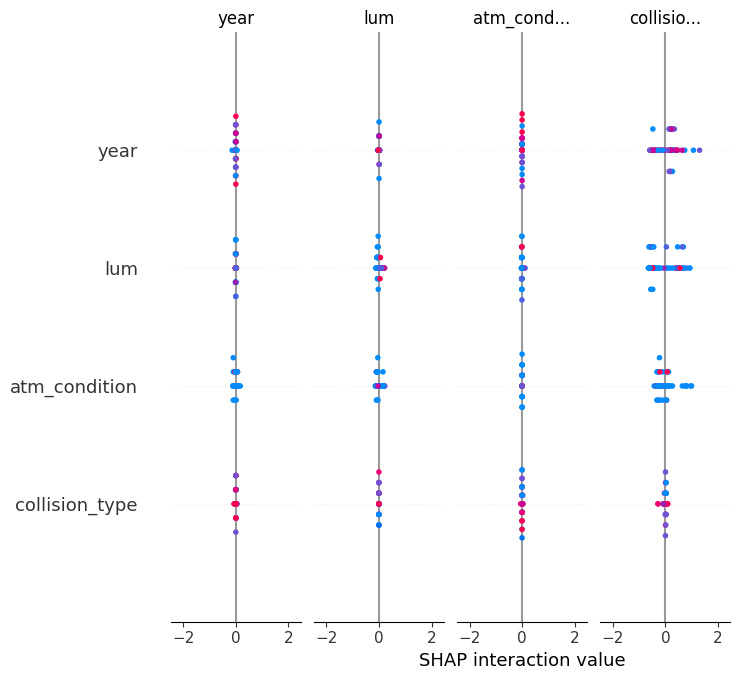

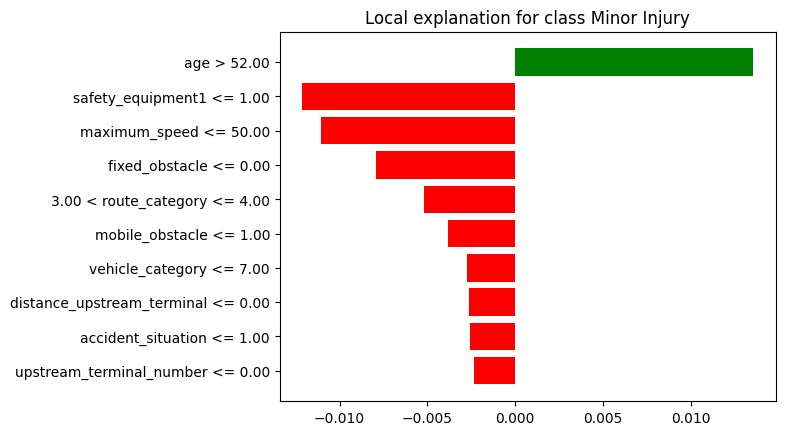

In [3]:
# Load the trained model and test data
model_path = "model.pkl"
X_test_path = "X_test.csv"

if os.path.exists(model_path) and os.path.exists(X_test_path):
    with open(model_path, "rb") as f:
        model = pickle.load(f)

    X_test = pd.read_csv(X_test_path)
    
    # Use a small sample from X_test to reduce computation time for KernelExplainer
    X_sample = X_test.sample(n=50, random_state=42)
    
    # SHAP KernelExplainer (CPU-friendly)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample)
   
    # SHAP Summary Plot
    shap.summary_plot(shap_values, X_sample, show=False)
    fig_summary = plt.gcf()

    # LIME Explanation for a single prediction
    explainer_lime = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_test.values,
        feature_names=X_test.columns,
        class_names=['Uninjured', 'Minor Injury', 'Hospitalized Injury', 'Fatal'],
        mode='classification'
    )

    exp = explainer_lime.explain_instance(X_test.iloc[0], model.predict_proba)
    fig_lime = exp.as_pyplot_figure()

    # Display results
    plt.show(fig_summary)
    plt.show(fig_lime)

else:
    print("Model or test dataset not found.")
